In [1]:
import torchvision.models as models                   

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
from numpy import asarray, percentile, tile
import torch.nn as nn
from scipy.ndimage import gaussian_filter
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.225] )
def image_converter(im):
    im_copy = im.cpu()
    
    im_copy = denormalize(im_copy.clone().detach()).numpy()
    im_copy = im_copy.transpose(1,2,0)
    im_copy = im_copy.clip(0, 1) 
    return im_copy

def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [3]:
# def act_max(model, 
#     input, 
#     layer_activation, 
#     layer_name, 
#     unit, 
#     steps=5, 
#     alpha=torch.tensor(0.005),
#     theta_decay=0.1,
#     theta_every=4,
#     theta_width=0.1,
#     ):

#     best_activation = -float('inf')
#     best_img = input
#     normalizer = torch.norm(input)
#     layer_out = layer_activation[layer_name]
#     # list(model.children())[-1].register_backward_hook(layer_hook(backward_layer_activation, first_layer))
#     # b_layer_out = backward_layer_activation[first_layer]
#     for k in range(steps):
#         input.requires_grad_(True)
#         input.retain_grad() 
#         model.zero_grad()
#         old_norm = torch.norm(input)
#         # Propogate image
#         model(input)

#         # compute gradients
#         layer_out[0][unit].backward(retain_graph=True)
#         img_grad = input.grad
#         #img_grad = b_layer_out[0]



#         # Gradient Step
#         input = torch.add(input, torch.mul(img_grad, alpha))

#         #L2_Decay
#         input = torch.mul(input, (1.0 - theta_decay))

#         normalizer = (normalizer * (k+1) + torch.norm(input))/(k+2)

#         new_norm = torch.norm(input)
#         input = torch.mul(input, old_norm/new_norm)

#         #assert(math.isclose(torch.norm(input), normalizer, rel_tol=1e-2))
#         #Gaussian Blurr
#         if k % theta_every is 0:
#             temp = input.squeeze(0)
#             temp = temp.detach().cpu().numpy()
#             for channel in range(3):
#                 cimg = gaussian_filter(temp[channel], theta_width)
#                 temp[channel] = cimg
#             temp = torch.from_numpy(temp).cuda()
#             input = temp.unsqueeze(0)

#         print('step: ', k, 'activation: ', layer_out[0][unit])
#         if k % 10 == 0:
#             final_image = image_converter(input.squeeze(0))
#             #plt.imshow(final_image)
#             #plt.show()
#             print('step: ', k, 'activation: ', layer_out[0][unit])

#         # Keep highest activation
#         if layer_out[0][unit] > best_activation:
#             best_activation = layer_out[0][unit]
#             best_img = input
#     return (best_activation, best_img)

In [4]:
def act_max(model, 
    inp_img, 
    layer_activation, 
    layer_name, 
    unit, 
    steps=5, 
    alpha=torch.tensor(0.005),
    theta_decay=0.1,
    theta_every=4,
    theta_width=0.1,
    ):

    best_activation = -float('inf')
    best_img = inp_img
    for k in range(steps):
        inp_img.requires_grad_(True)
        inp_img.retain_grad() 
        inp_img = inp_img.cuda()
        old_norm = torch.norm(inp_img)
        
        # Propagate image
        model(inp_img)
        layer_out = layer_activation[layer_name]

        # Compute gradients
        layer_out[0][unit].backward(retain_graph=True)
        img_grad = inp_img.grad

        # Gradient Step
        inp_img = torch.add(inp_img, torch.mul(img_grad, alpha))

        new_norm = torch.norm(inp_img)
        inp_img = torch.mul(inp_img, old_norm/new_norm)

        # #L2_Decay
        # input = torch.mul(input, (1.0 - theta_decay))

        # #Gaussian Blur
        # if k % theta_every == 0:
        #   temp = input.squeeze(0)
        #   temp = temp.detach().numpy()
        #   for channel in range(3):
        #       cimg = gaussian_filter(temp[channel], theta_width)
        #       temp[channel] = cimg
        #   temp = torch.from_numpy(temp)
        #   input = temp.unsqueeze(0)

        # print('step: ', k, 'activation: ', layer_out[0][unit])
        # if k % 10 == 0:
        if k == steps - 1:
            final_image = image_converter(inp_img.squeeze(0))
            plt.imshow(final_image)
            plt.show()
            print('step: ', k, 'activation: ', layer_out[0][unit])

        # Keep highest activation
        # Some sort of penalization for high-activation-inputs generating high-activation-outputs: why 0.05? why linear?
        if layer_out[0][unit] - (0.05 * torch.norm(inp_img)) > best_activation:
            best_activation = layer_out[0][unit]
            best_img = inp_img
    return (best_activation, best_img)

In [5]:
def load_image(img_path, device=False):
    img = Image.open(img_path)
    img = img.resize((256, 256))
    img = img.convert('RGB')
    img = asarray(img).transpose(-1, 0, 1)
    img = img/255
    img = torch.from_numpy(img) 
    img = normalize(img)
    img = img.unsqueeze(0)
    img.requires_grad = True
    if device:
        img = img.type(torch.cuda.FloatTensor)
    else:
        img = img.type(torch.FloatTensor)
    return img


In [6]:
model = models.resnet50(pretrained = True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

model.eval().to(device)

Using cache found in C:\Users\neilh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# uris = [
#     'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
# ]
# uri = 'https://salient-imagenet.cs.umd.edu/feature_visualization/class_130/feature_484/images/0.jpg'
# input = utils.prepare_input_from_uri(uri).to(device)
#input = load_image('flamingo_image.jpg')
input1 = torch.rand(3, 256, 256, requires_grad=True)
input1 = input1.type(torch.FloatTensor)
input1 = input1.unsqueeze(0)
input2 = torch.rand(3, 256, 256, requires_grad=True)
input2 = input2.type(torch.FloatTensor)
input2 = input2.unsqueeze(0)
input3 = torch.rand(3, 256, 256, requires_grad=True)
input3 = input3.type(torch.FloatTensor)
input3 = input3.unsqueeze(0)

In [8]:
# result = resnet50(input)
# value = result.detach().numpy()
# k = max(value[0])
def layers_name_type(network):
    name_type_pair = [(key, value) for key, value in network.named_modules()]
    return name_type_pair


In [9]:
activation_dictionary = {}
# backward_activation_dictionary = {}
# print(layers_name_type(model)[-1])
layer_name = 'classifier_final'
#first_layer_name = 'conv1'
list(model.children())[-1].register_forward_hook(layer_hook(activation_dictionary, layer_name))


In [10]:
steps = 100
#unit = list(value[0]).index(k)   
unit = 130               
alpha = torch.tensor(1) 
#input = torch.add(input, torch.norm(input, float('inf')), alpha = (-1)*0.1)   
input1 = input1.cuda()
input2 = input2.cuda()
input3 = input3.cuda()

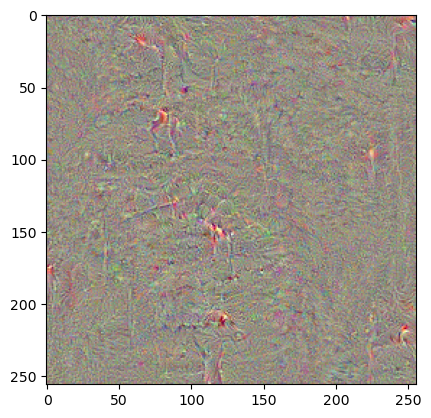

step:  99 activation:  tensor(213.1711, device='cuda:0', grad_fn=<SelectBackward0>)


In [11]:
acivation1, output1 = act_max(model=model,
                inp_img=input1,
                layer_activation = activation_dictionary,
                layer_name = layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                )


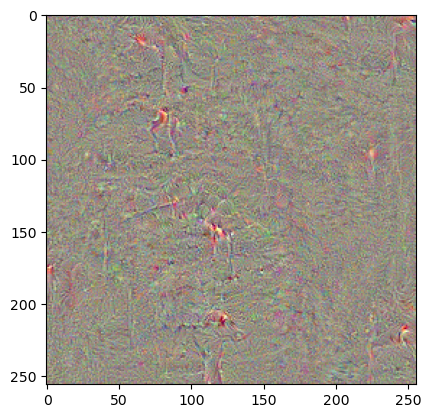

tensor(210.5581, device='cuda:0', grad_fn=<SelectBackward0>)


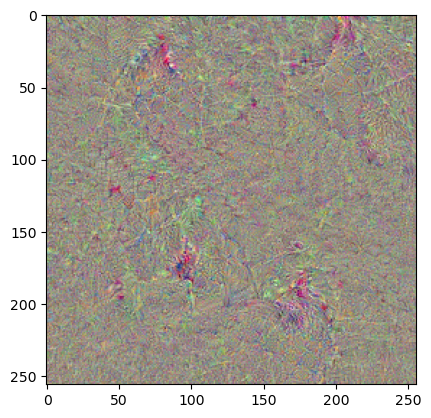

step:  99 activation:  tensor(193.8134, device='cuda:0', grad_fn=<SelectBackward0>)
7


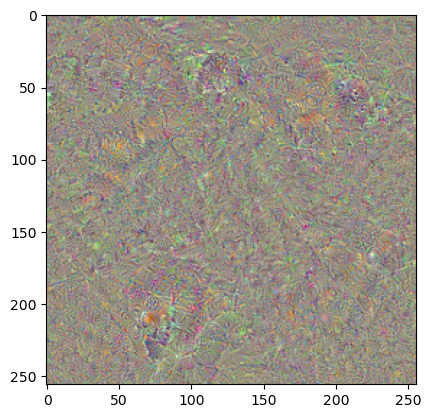

step:  99 activation:  tensor(172.3692, device='cuda:0', grad_fn=<SelectBackward0>)
380


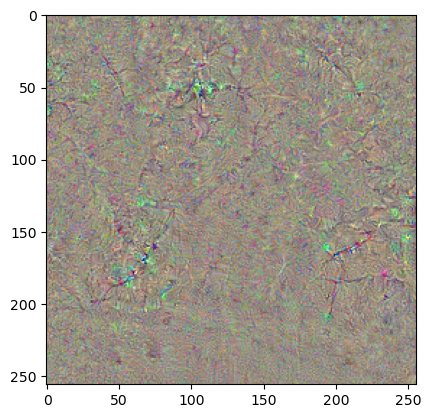

step:  99 activation:  tensor(208.0317, device='cuda:0', grad_fn=<SelectBackward0>)
300


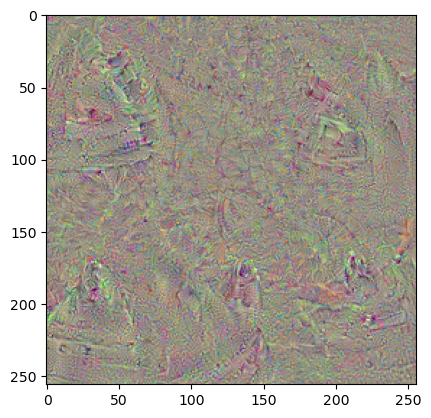

step:  99 activation:  tensor(244.3427, device='cuda:0', grad_fn=<SelectBackward0>)
606


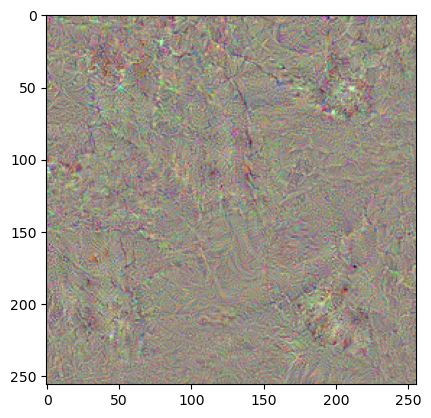

step:  99 activation:  tensor(189.4276, device='cuda:0', grad_fn=<SelectBackward0>)
218


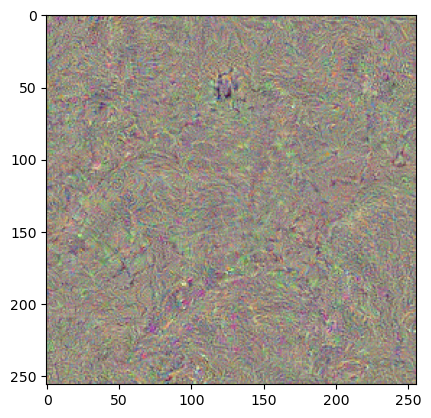

step:  99 activation:  tensor(203.1772, device='cuda:0', grad_fn=<SelectBackward0>)
342


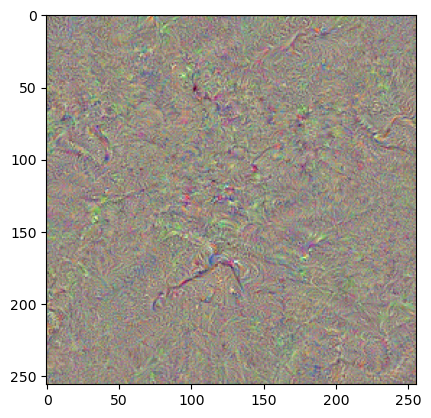

step:  99 activation:  tensor(208.5198, device='cuda:0', grad_fn=<SelectBackward0>)
58


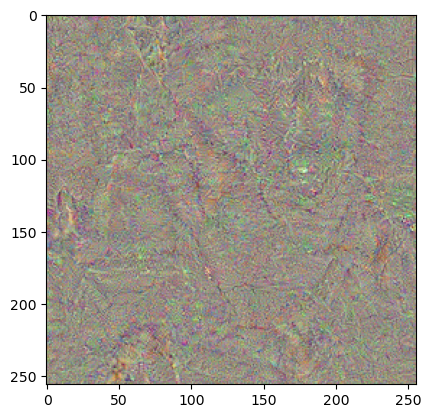

step:  99 activation:  tensor(165.3832, device='cuda:0', grad_fn=<SelectBackward0>)
235


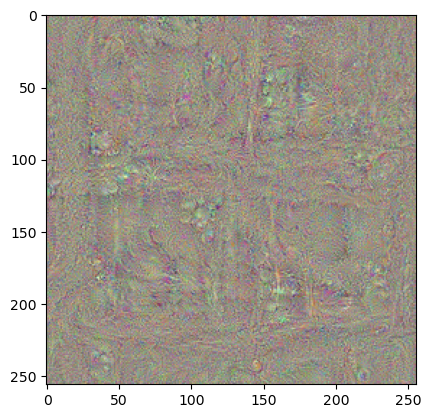

step:  99 activation:  tensor(131.9706, device='cuda:0', grad_fn=<SelectBackward0>)
495


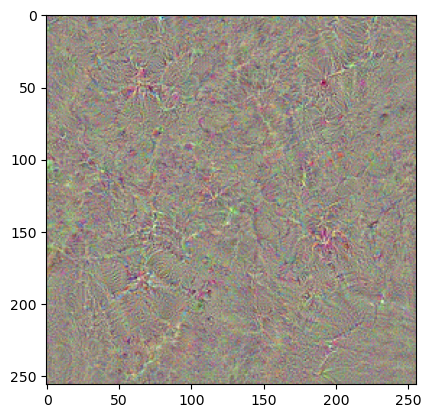

step:  99 activation:  tensor(216.4240, device='cuda:0', grad_fn=<SelectBackward0>)
815
None


In [12]:
# result = resnet50(output1)
# value = result.detach().numpy()
# k = max(value[0])
# index = list(value[0]).index(k)
# print(k)
# print(acivation)
# print(index)
# print(unit)
#ori = load_image('flamingo_image.jpg')
#ori = image_converter(ori.squeeze(0))
#plt.imshow(ori)
#plt.show()
#plt.imshow(abs(ori - final_image))
#plt.show()
#assert(unit == index)
final_image1 = image_converter(output1.squeeze(0))
plt.imshow(final_image1)
plt.show()
# final_image2 = image_converter(output2.squeeze(0))
# plt.imshow(final_image2)
# plt.show()
# final_image3 = image_converter(output3.squeeze(0))
# plt.imshow(final_image3)
# plt.show()
print(acivation1)
# avg_img = np.average(np.array((final_image1, final_image2, final_image3)))
# print(avg_img.shape)
# avg_img = torch.mul(torch.add(torch.add(output1.squeeze(0), output2.squeeze(0)), output3.squeeze(0)), 1/3)
# plt.imshow(image_converter(avg_img))
# plt.show()

import random

def running_num(num):
    res = []
    for i in range(num):

        activation_dictionary = {}
        layer_name = 'classifier_final'
        list(model.children())[-1].register_forward_hook(layer_hook(activation_dictionary, layer_name))
        steps = 100
        alpha = torch.tensor(1) 
        unit = random.randint(1, 1000)
        input1 = torch.rand(3, 256, 256, requires_grad=True)
        input1 = input1.type(torch.FloatTensor)
        input1 = input1.unsqueeze(0)
        input1 = input1.cuda()
        acivation1, output1 = act_max(model=model,
                inp_img=input1,
                layer_activation = activation_dictionary,
                layer_name = layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                )
        res.append((unit, acivation1))
        print(unit)

print(running_num(10))

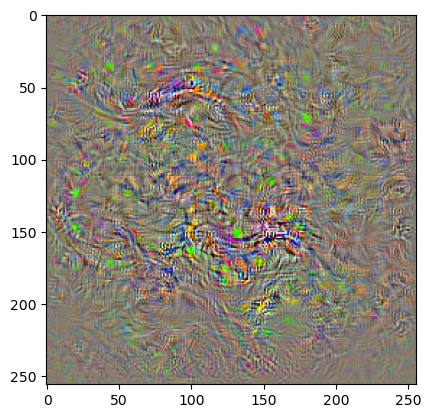

step:  299 activation:  tensor(537.8493, device='cuda:0', grad_fn=<SelectBackward0>)


In [15]:
alexnet = models.alexnet(weights='IMAGENET1K_V1')
alexnet.eval().to(device)
activation_dictionary = {}
layer_name = 'classifier_final'
list(alexnet.children())[-1].register_forward_hook(layer_hook(activation_dictionary, layer_name))
steps = 300
alpha = torch.tensor(1) 
unit = 58
input1 = torch.rand(3, 256, 256, requires_grad=True)
input1 = input1.type(torch.FloatTensor)
input1 = input1.unsqueeze(0)
input1 = input1.cuda()
acivation1, output1 = act_max(model=alexnet,
                inp_img=input1,
                layer_activation = activation_dictionary,
                layer_name = layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                )
